## Import the libraries

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Library/Frameworks/Python.framework/Versi

scanpy==1.9.3 anndata==0.9.1 umap==0.5.3 numpy==1.24.3 scipy==1.10.1 pandas==1.5.0 scikit-learn==1.2.2 statsmodels==0.14.0 python-igraph==0.10.4 louvain==0.8.0 pynndescent==0.5.10


In [3]:
results_file = 'write/24hpa_data.h5ad'  # the file that will store the analysis results


In [4]:
#Read in the count matrix into an AnnData object
adata = sc.read_10x_mtx(
    '/Users/okendojo/Desktop/scRNA/hui_data/reprocessedData/24hpa_filtered_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

... reading from cache file cache/Users-okendojo-Desktop-scRNA-hui_data-reprocessedData-24hpa_filtered_feature_bc_matrix-matrix.h5ad


In [5]:
adata

AnnData object with n_obs × n_vars = 3170 × 25434
    var: 'gene_ids', 'feature_types'

# Preprocessing
Show those genes that yield the highest fraction of counts in each single cell, across all cells.



normalizing counts per cell
    finished (0:00:00)


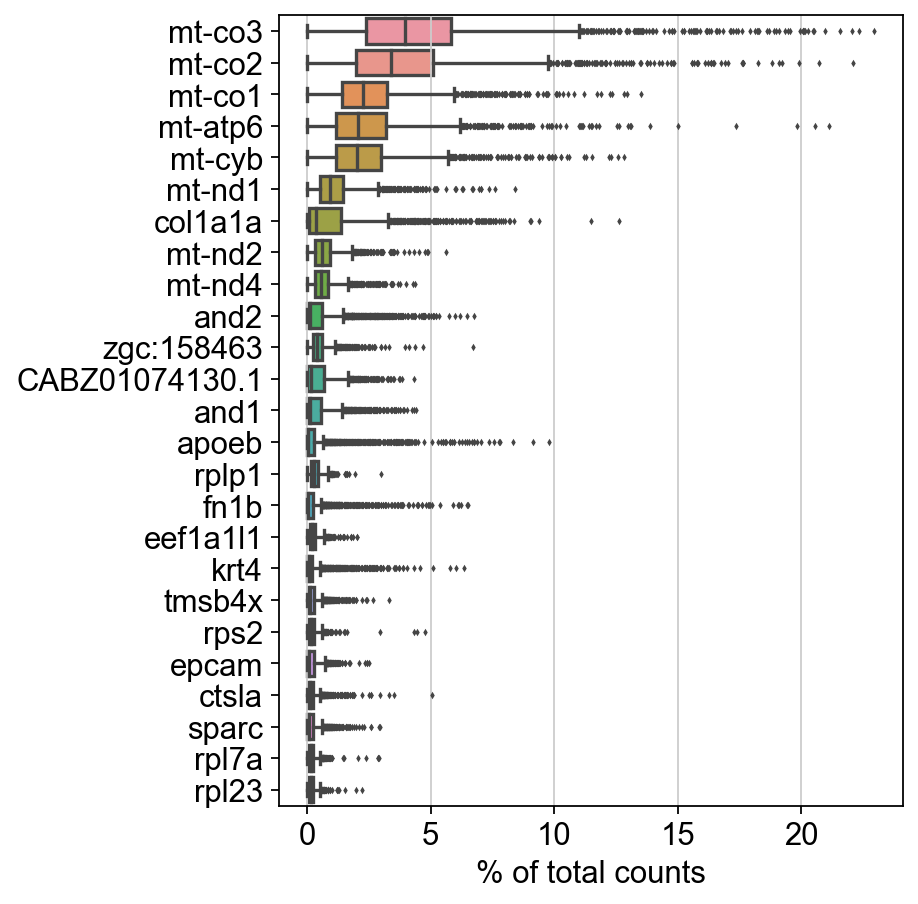

In [6]:
sc.pl.highest_expr_genes(adata, n_top=25, ) # In this case there seems to be a high proprtion of mt reads in our data


In [7]:
# basic filtering 
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 110 cells that have less than 200 genes expressed
filtered out 5252 genes that are detected in less than 3 cells


In [8]:
# Let’s assemble some information about mitochondrial genes, which are important for quality control.

adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [9]:
adata

AnnData object with n_obs × n_vars = 3060 × 20182
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

## A violin plot of some of the computed quality measures:

the number of genes expressed in the count matrix
the total counts per cell
the percentage of counts in mitochondrial genes

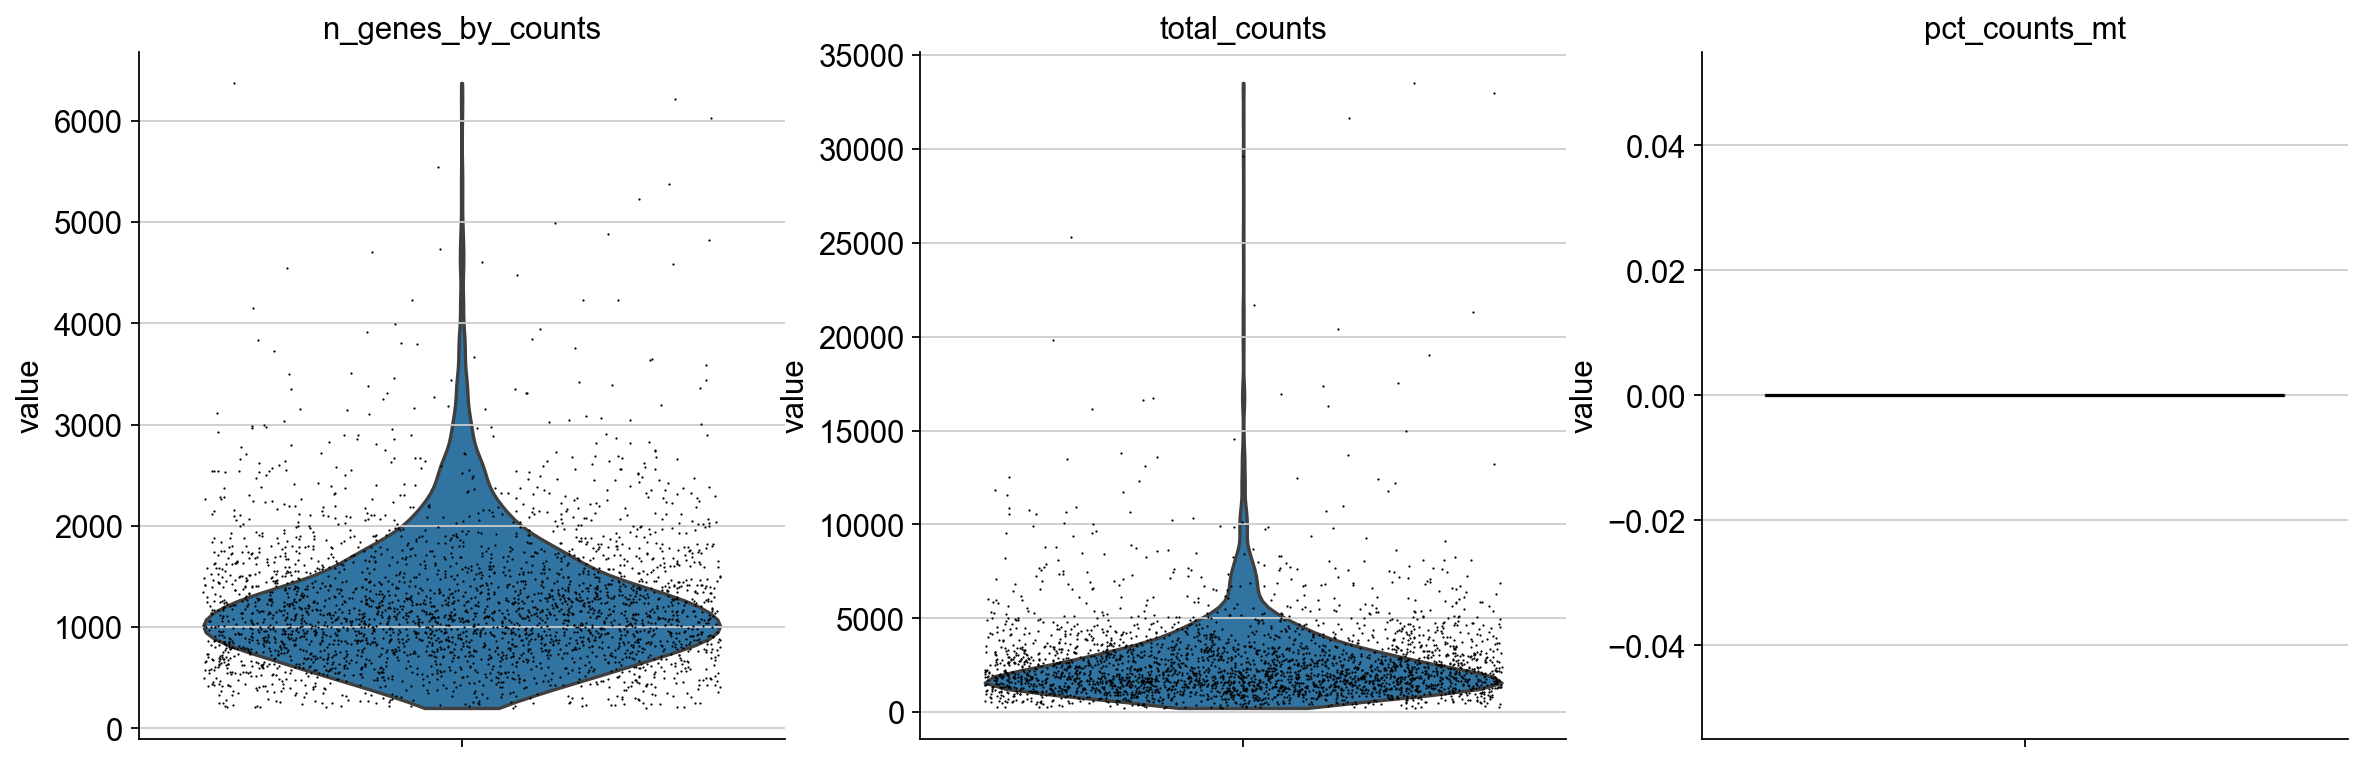

In [10]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

## Remove cells that have too many mitochondrial genes expressed or too many total counts:



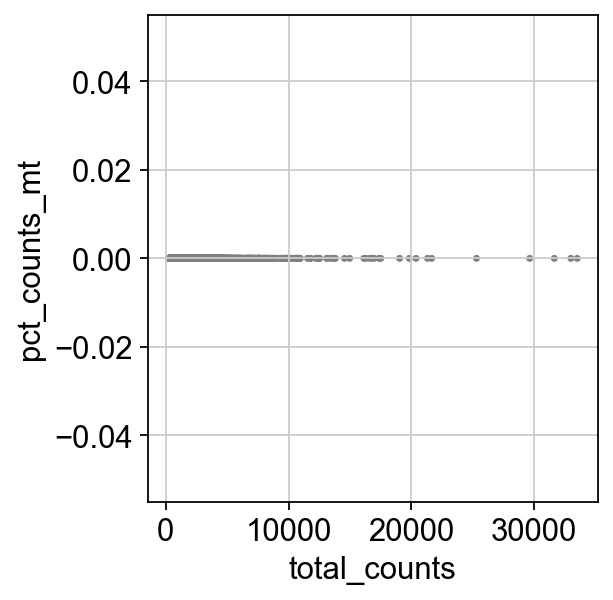

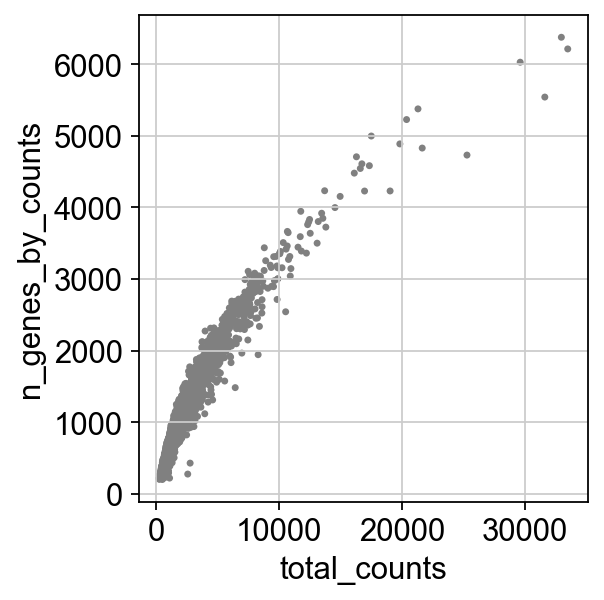

In [11]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [12]:
#Actually do the filtering by slicing the AnnData object.

adata = adata[adata.obs.n_genes_by_counts < 4000, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

In [13]:
adata

View of AnnData object with n_obs × n_vars = 3041 × 20182
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [14]:
# Total count normalization accross the cells
sc.pp.normalize_total(adata, target_sum=1e4)


normalizing counts per cell
    finished (0:00:00)


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [15]:
adata

AnnData object with n_obs × n_vars = 3041 × 20182
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [16]:
# Logarithmize the data
sc.pp.log1p(adata)

In [17]:
# Identify highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


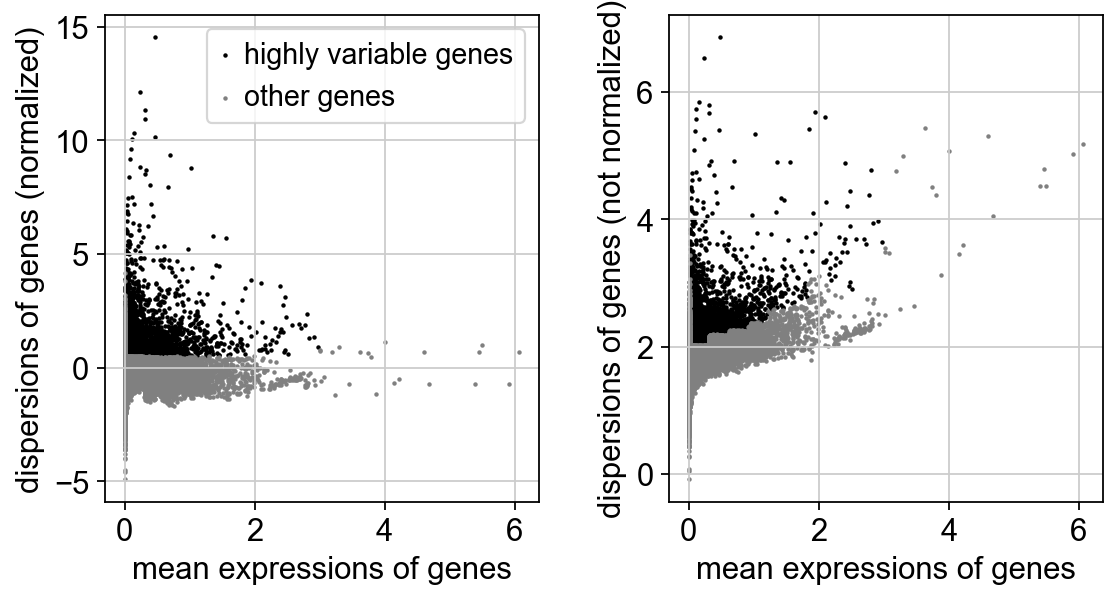

In [18]:
sc.pl.highly_variable_genes(adata)

In [20]:
# Set .raw anndata for later use
adata.raw = adata

In [21]:
# Do the filtering
adata = adata[:, adata.var.highly_variable]

In [22]:
adata

View of AnnData object with n_obs × n_vars = 3041 × 4213
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [23]:
# Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.

sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])


regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:26)


normalizing counts per cell
    finished (0:00:00)


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


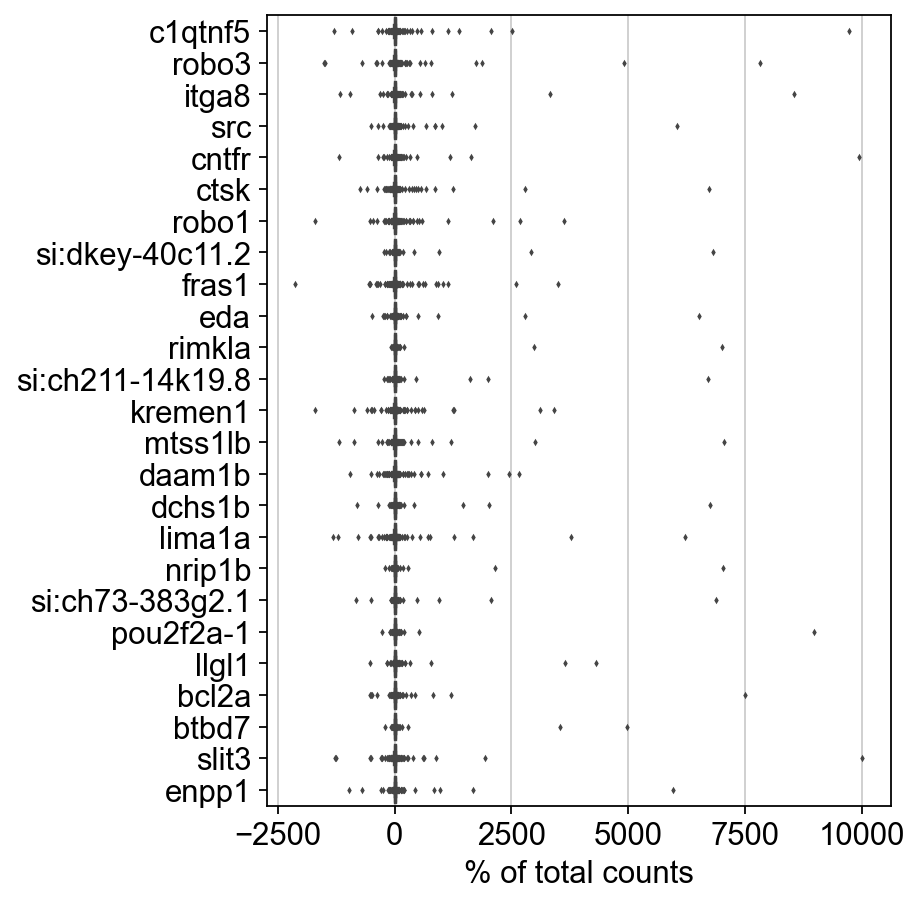

In [24]:
sc.pl.highest_expr_genes(adata, n_top=25, ) # re-check your data to determine highly variable genes again!


In [25]:
# Scale each gene to unit variance. Clip values exceeding standard deviation 10.

sc.pp.scale(adata, max_value=10)


## Principal component analysis
Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.



In [26]:
sc.tl.pca(adata, svd_solver='arpack')


computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)


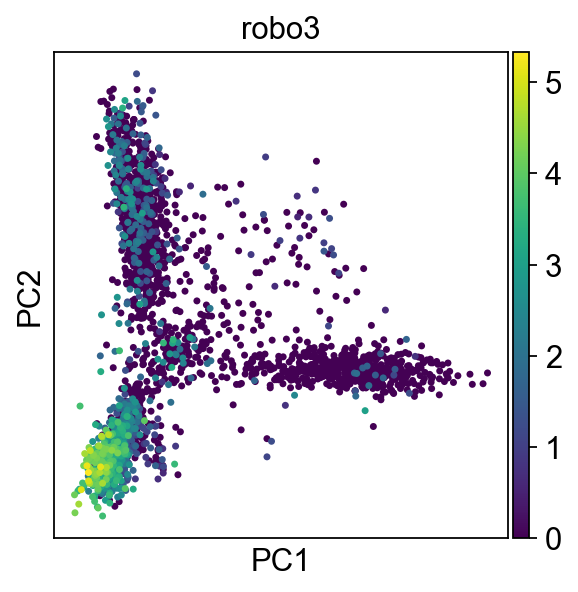

In [27]:
# make scatterplot
sc.pl.pca(adata, color='robo3')


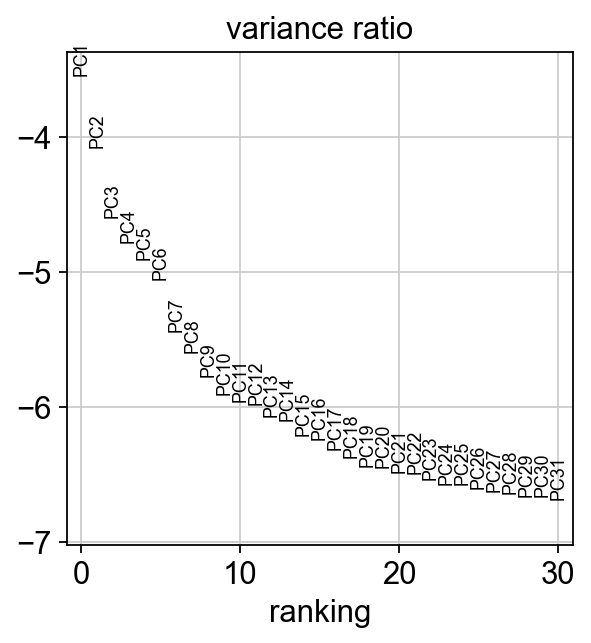

In [28]:
# Inspect the contribution of each PC
sc.pl.pca_variance_ratio(adata, log=True)


In [29]:
#Save the results
results_file = 'write/preprocessed24hpa_data.h5ad'  # the file that will store the analysis results

adata.write(results_file)


In [30]:
adata

AnnData object with n_obs × n_vars = 3041 × 4213
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [31]:
## Computing the neighborhood graph
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)


computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)


In [32]:
adata

AnnData object with n_obs × n_vars = 3041 × 4213
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

## Embedding the neighborhood graph


In [36]:
sc.tl.leiden(adata)
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata, init_pos='paga')

running Leiden clustering
    finished: found 20 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


KeyError: 'paga'

In [48]:
adata

AnnData object with n_obs × n_vars = 3041 × 4213
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'louvain', 'leiden'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'louvain', 'leiden', 'paga', 'leiden_sizes', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [49]:
sc.tl.umap(adata)


computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)


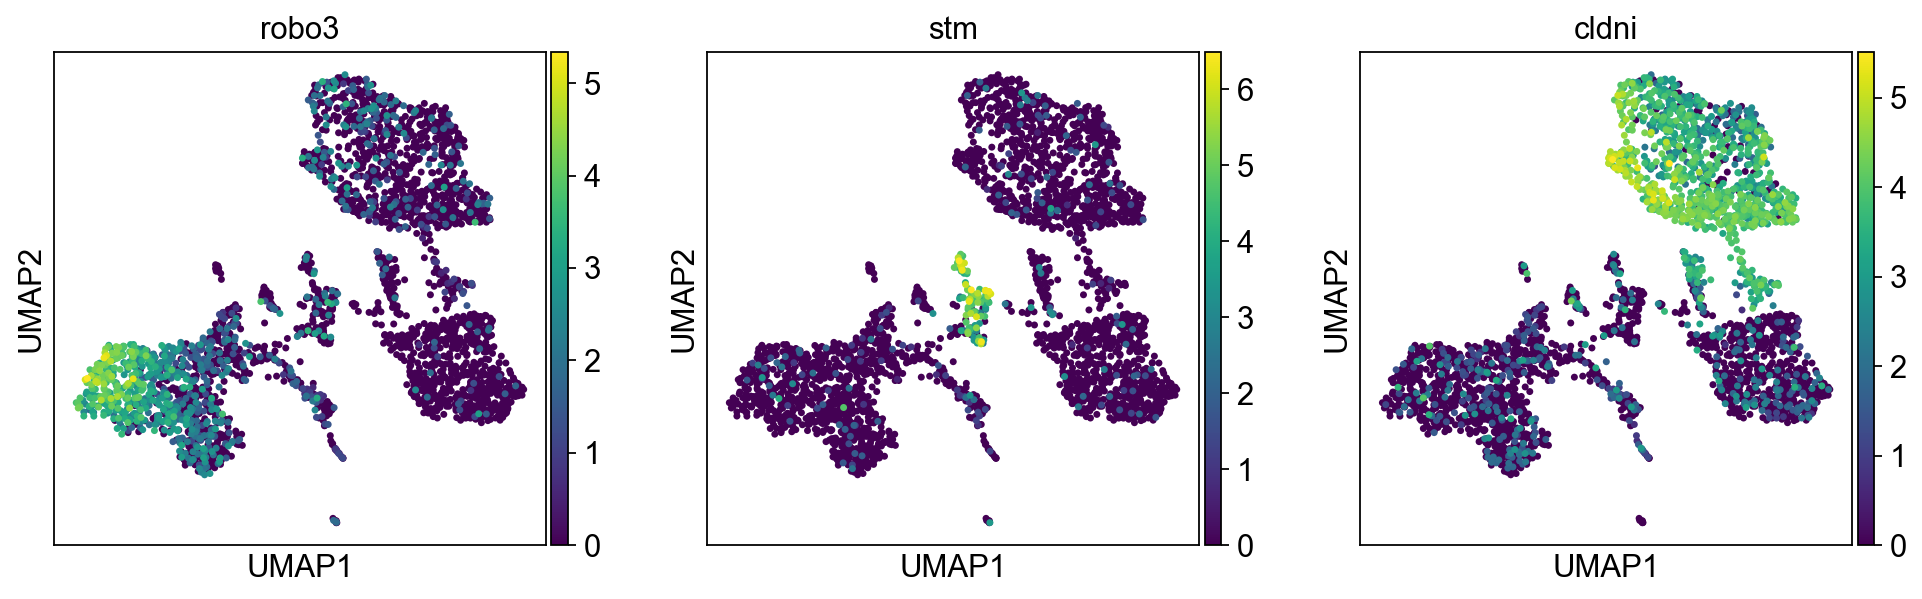

In [50]:
sc.pl.umap(adata, color=['robo3', 'stm', 'cldni'])


## Clustering the neighborhood graph
As with Seurat and many other frameworks, we recommend the Leiden graph-clustering method (community detection based on optimizing modularity) by Traag *et al.* (2018). Note that Leiden clustering directly clusters the neighborhood graph of cells, which we already computed in the previous section.



In [51]:
sc.tl.leiden(adata)


running Leiden clustering
    finished: found 20 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


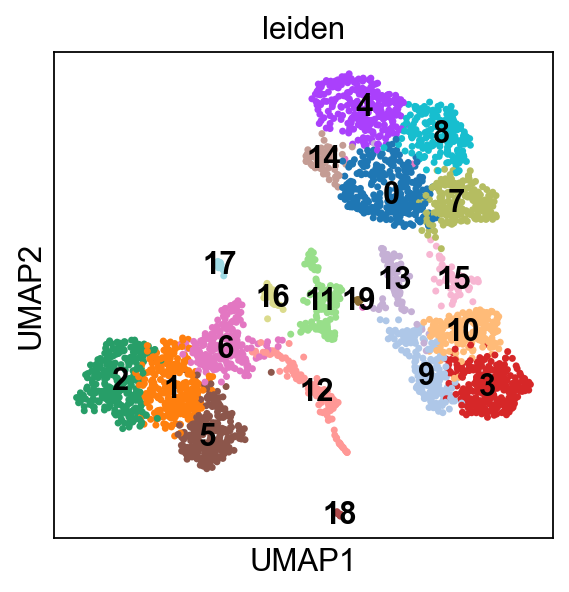

In [57]:
# Plot the clusters
sc.pl.umap(adata, color=['leiden'],legend_loc="on data")


In [58]:
#save the results
adata.write(results_file)


# Finding marker genes
Let us compute a ranking for the highly differential genes in each cluster. For this, by default, the .raw attribute of AnnData is used in case it has been initialized before. The simplest and fastest method to do so is the t-test.

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


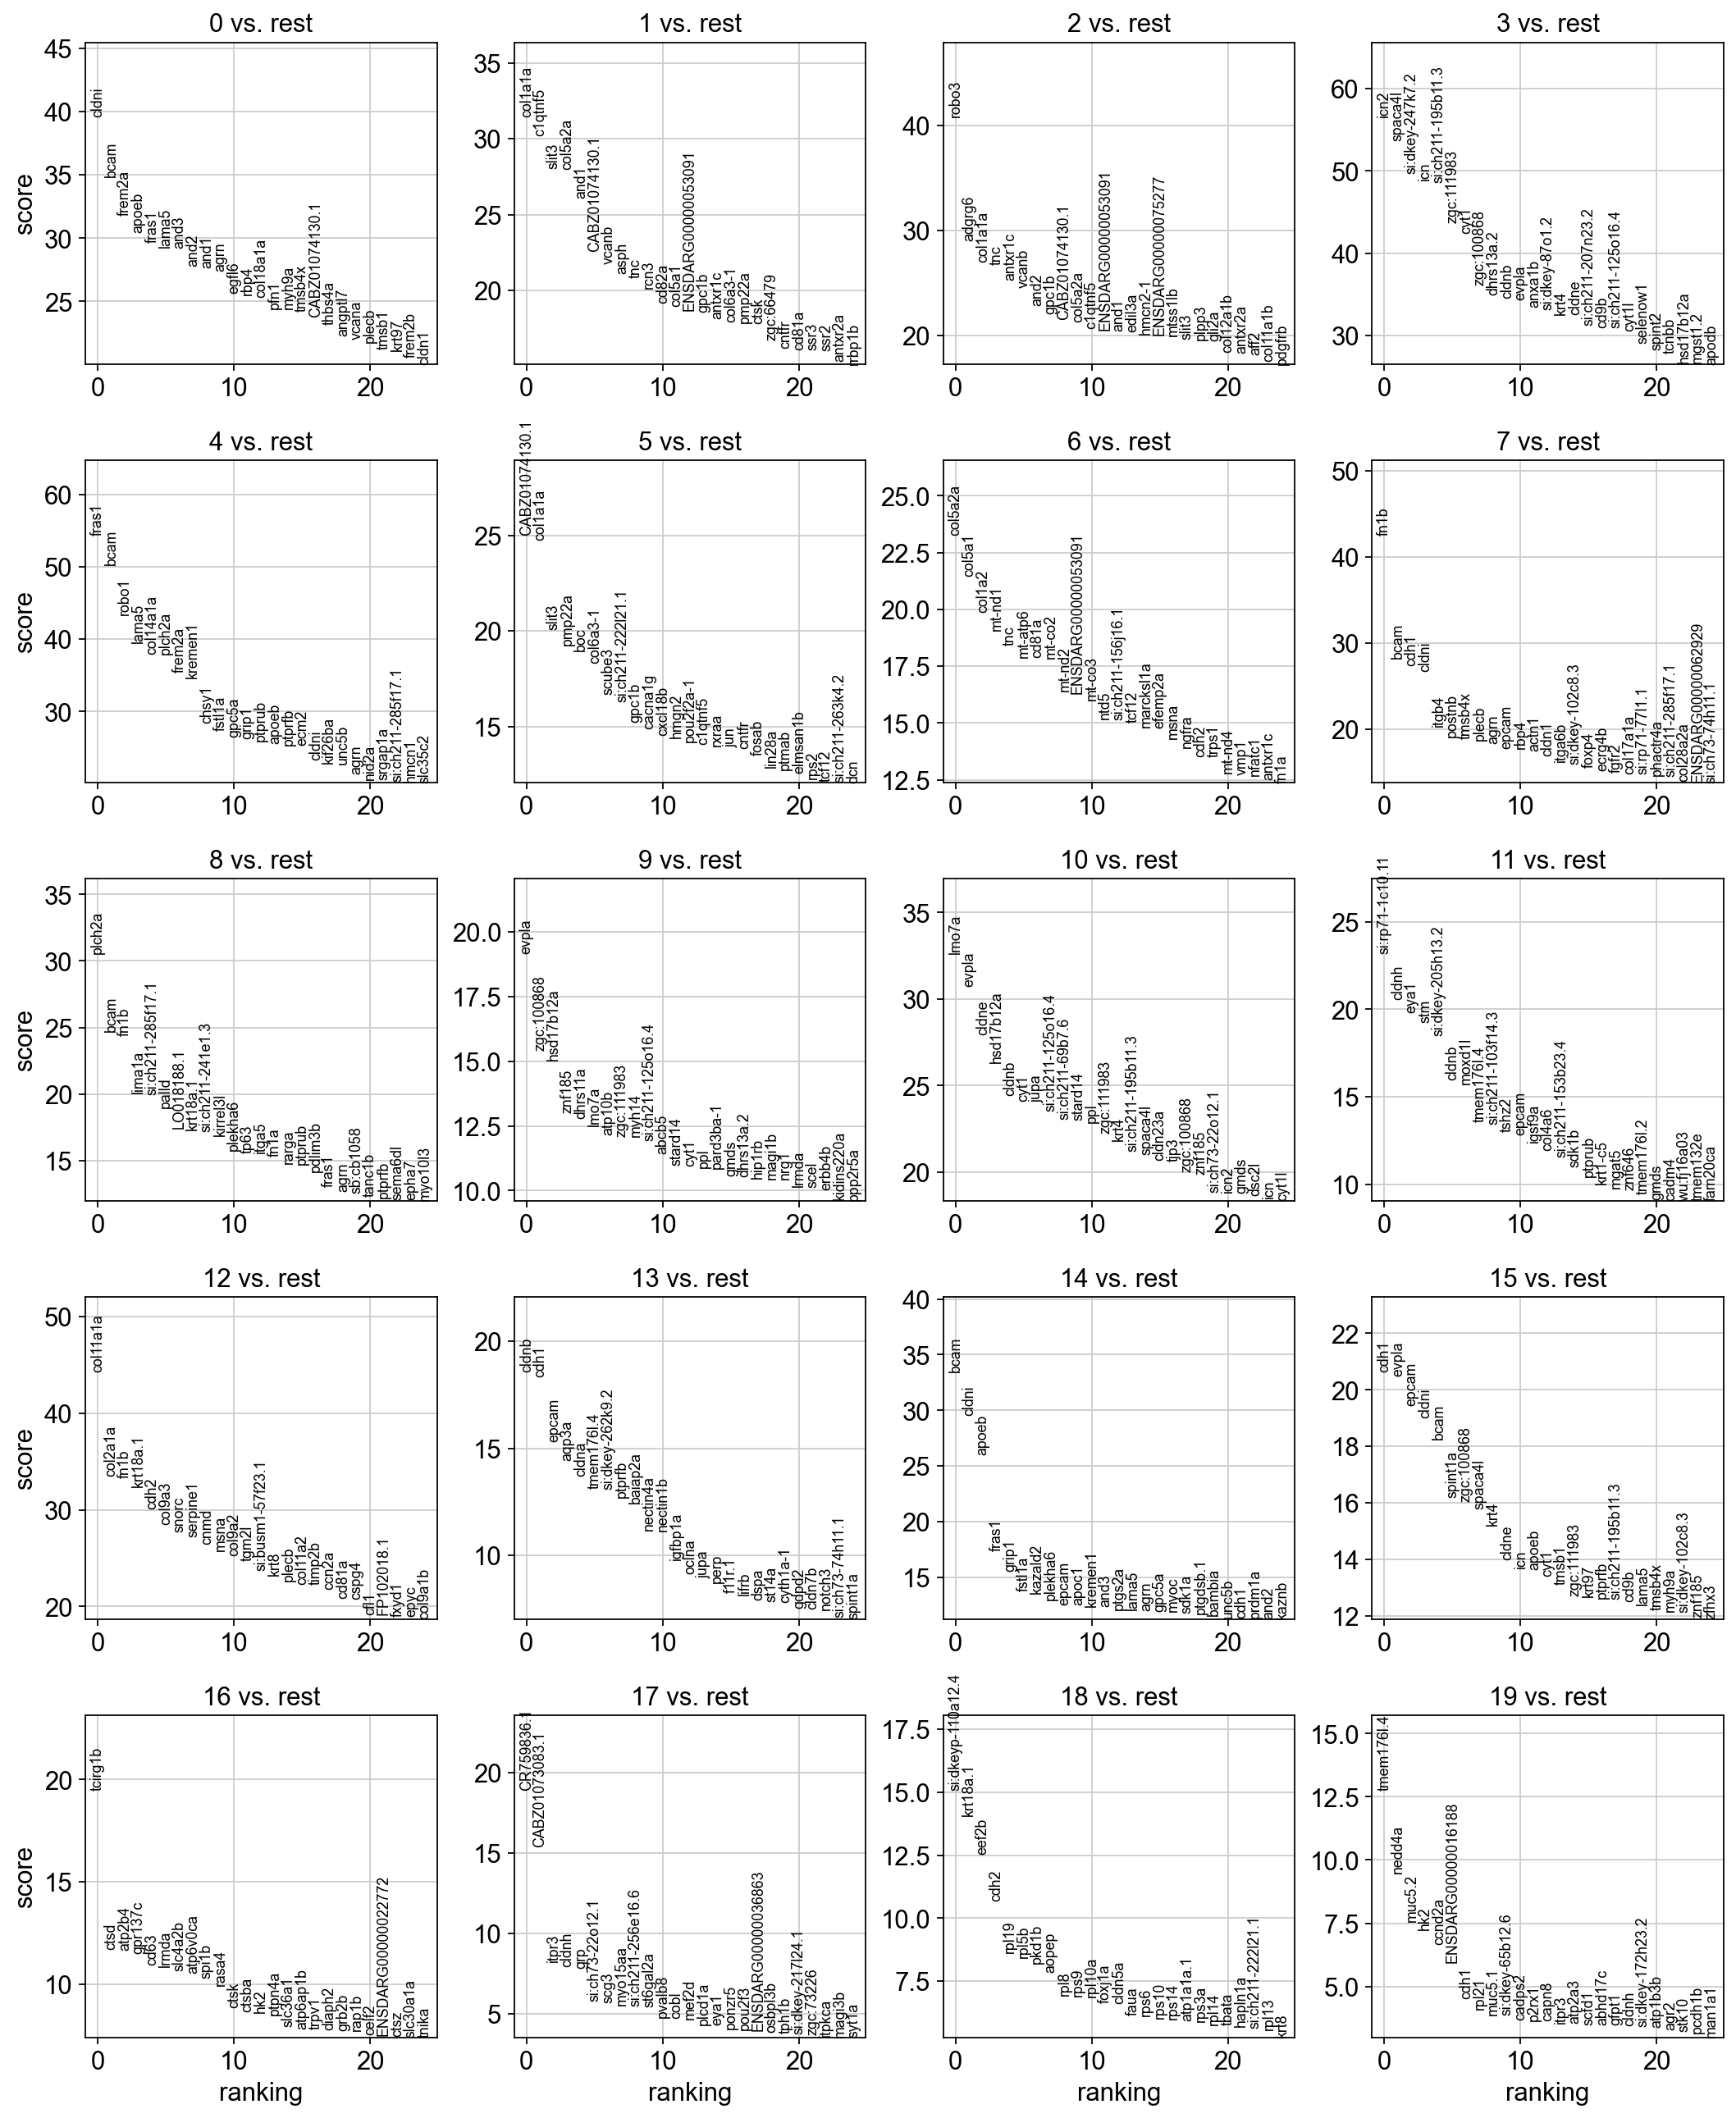

In [59]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [60]:
sc.settings.verbosity = 2  # reduce the verbosity

ranking genes
    finished (0:00:02)


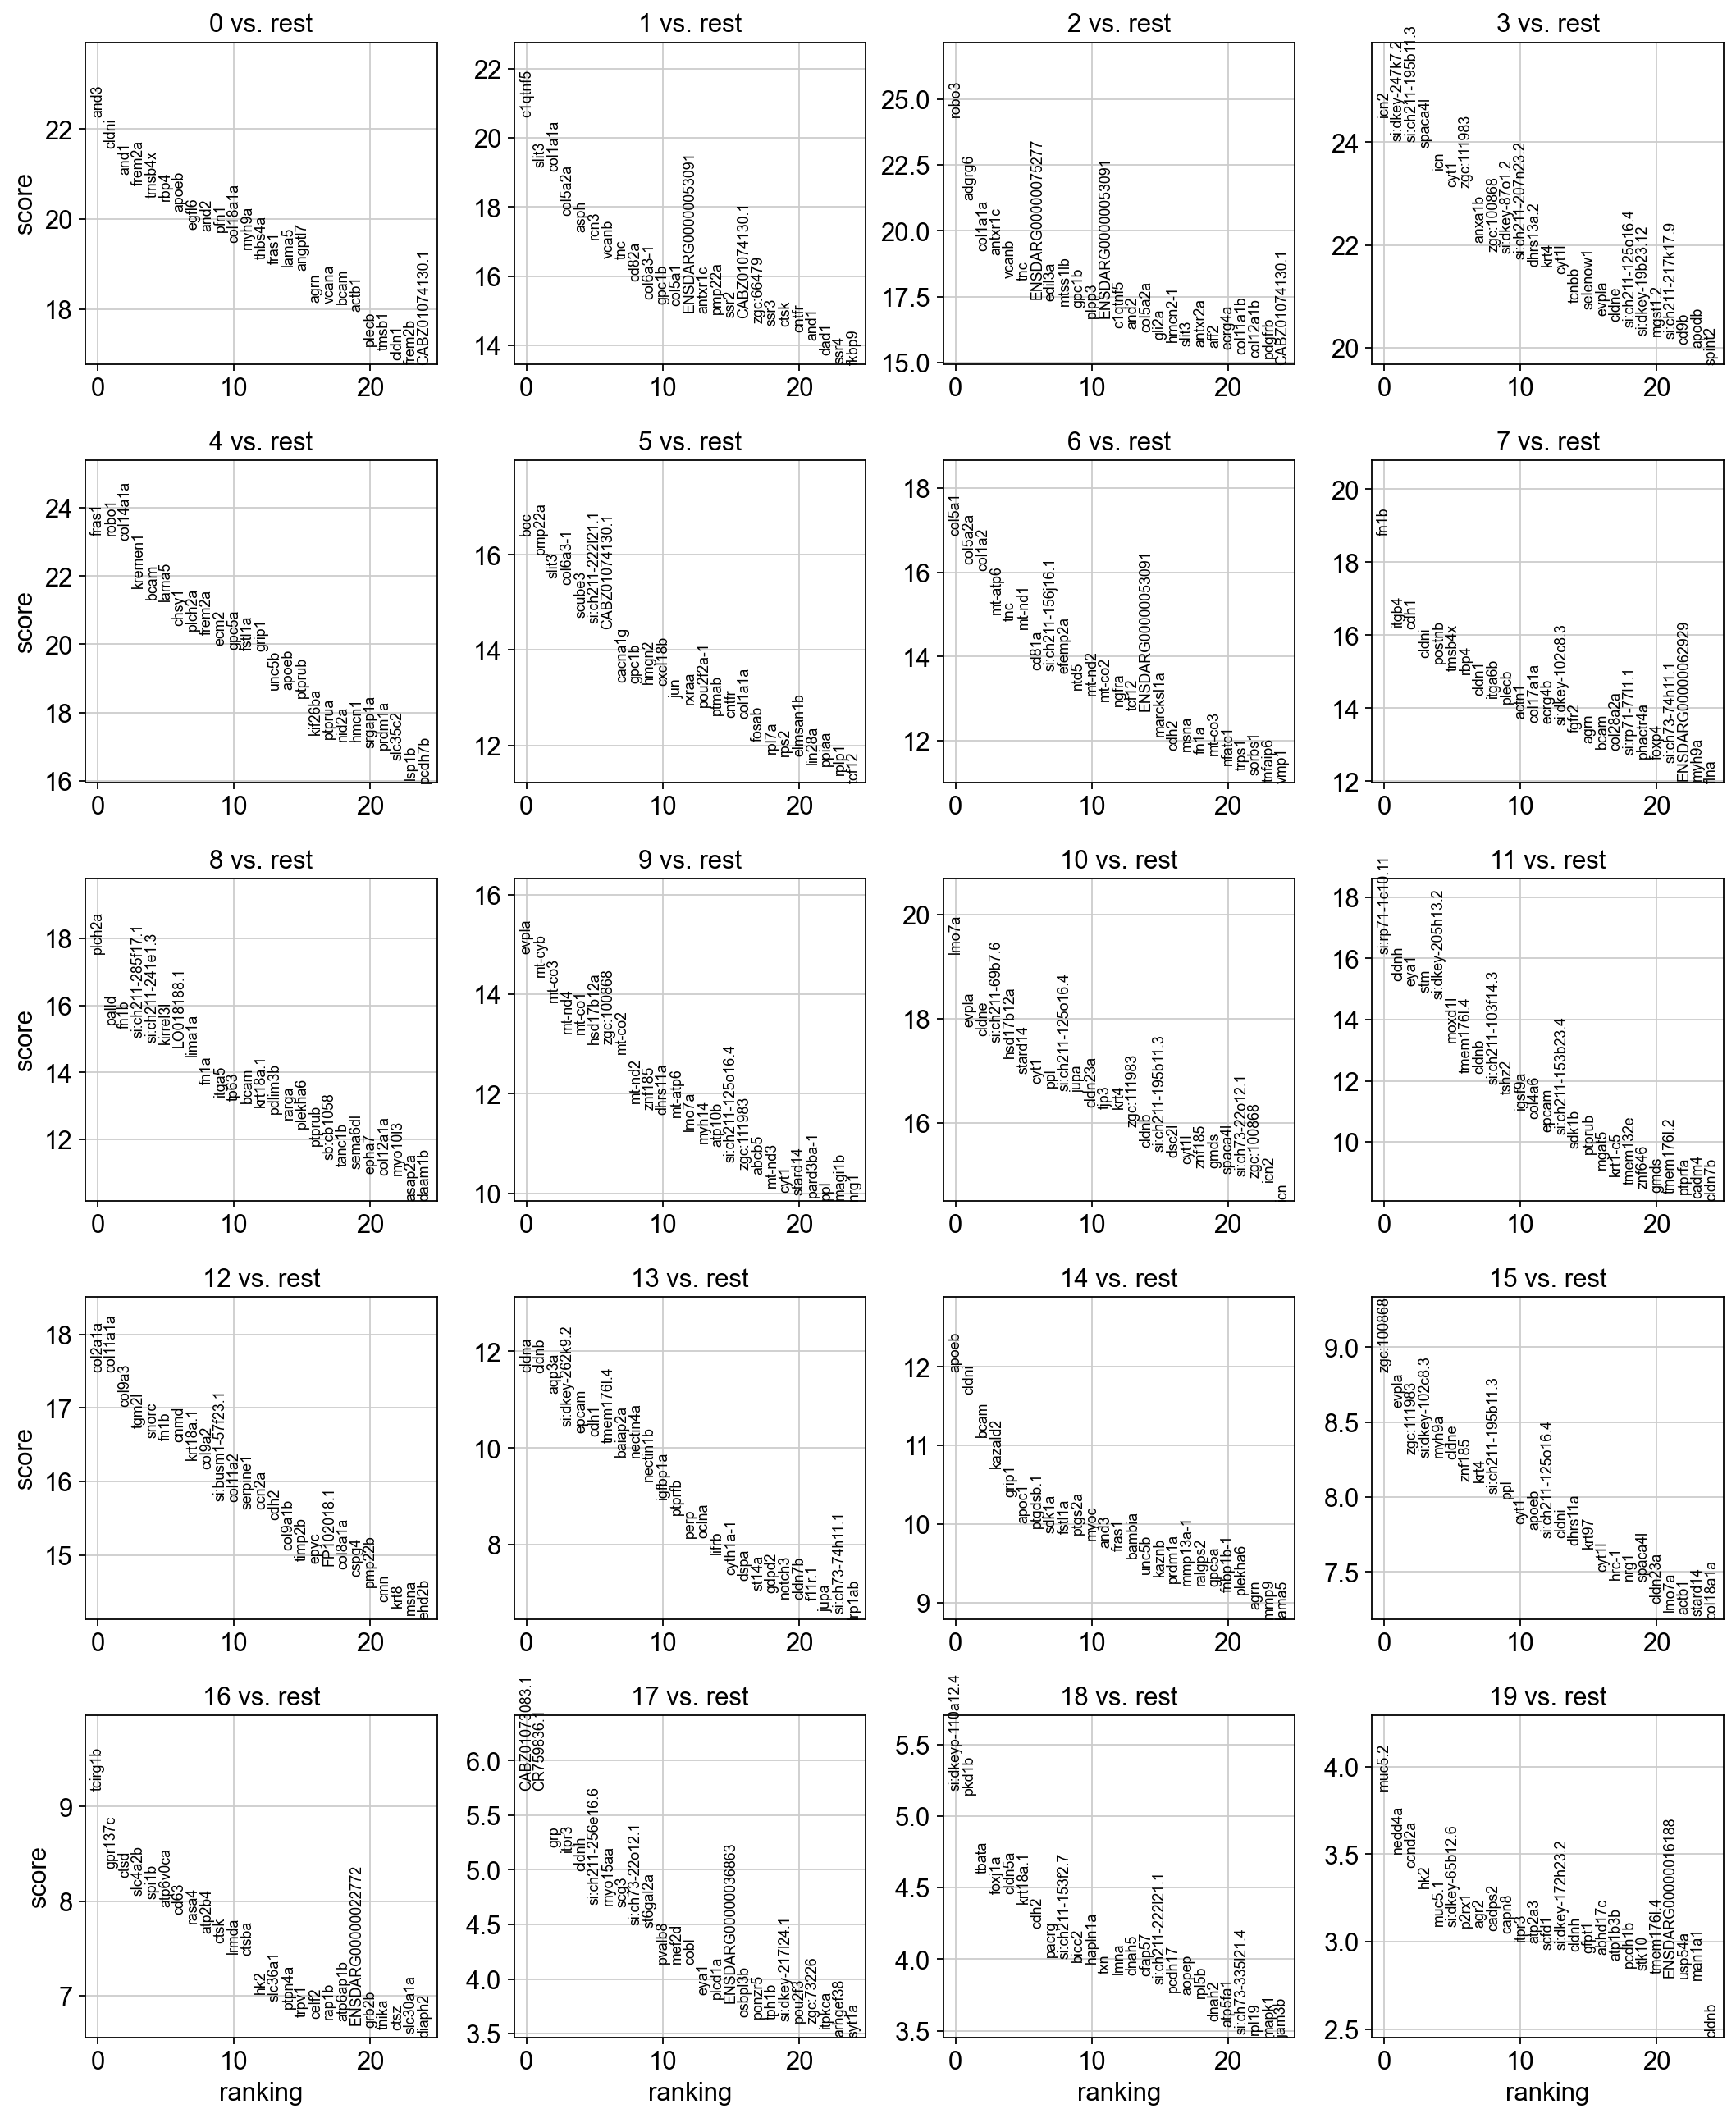

In [61]:
## Use wilcoxon test
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [62]:
adata.write(results_file)

In [65]:
#Show the top 10 ranked genes per cluster
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(10)

0         1                   2                  3         4  \
0    and3   c1qtnf5               robo3               icn2     fras1   
1   cldni     slit3              adgrg6    si:dkey-247k7.2     robo1   
2    and1   col1a1a             col1a1a  si:ch211-195b11.3  col14a1a   
3  frem2a   col5a2a             antxr1c            spaca4l   kremen1   
4  tmsb4x      asph               vcanb                icn      bcam   
5    rbp4      rcn3                 tnc               cyt1     lama5   
6   apoeb     vcanb  ENSDARG00000075277         zgc:111983     chsy1   
7   egfl6       tnc              edil3a             anxa1b    plch2a   
8    and2     cd82a             mtss1lb         zgc:100868    frem2a   
9    pfn1  col6a3-1               gpc1b     si:dkey-87o1.2      ecm2   

                   5                  6       7                  8  \
0                boc             col5a1    fn1b             plch2a   
1             pmp22a            col5a2a   itgb4              palld   
2              slit3             col1a2    cdh1               fn1b   
3           col6a3-1            mt-atp6   cldni  si:ch211-285f17.1   
4             scube3                tnc  postnb   si:ch211-241e1.3   
5  si:ch211-222l21.1             mt-nd1  tmsb4x           kirrel3l   
6     CABZ01074130.1              cd81a    rbp4         LO018188.1   
7            cacna1g  si:ch211-156j16.1   cldn1             lima1a   
8              gpc1b            efemp2a  itga6b               fn1a   
9              hmgn2               ntd5   plecb              itga5   

            9                 10                 11                12  \
0       evpla              lmo7a    si:rp71-1c10.11           col2a1a   
1      mt-cyb              evpla              cldnh          col11a1a   
2      mt-co3              cldne               eya1            col9a3   
3      mt-nd4    si:ch211-69b7.6                stm             tgm2l   
4      mt-co1          hsd17b12a   si:dkey-205h13.2             snorc   
5   hsd17b12a            stard14             moxd1l              fn1b   
6  zgc:100868               cyt1         tmem176l.4              cnmd   
7      mt-co2                ppl              cldnb          krt18a.1   
8      mt-nd2  si:ch211-125o16.4  si:ch211-103f14.3            col9a2   
9      znf185               jupa              tshz2  si:busm1-57f23.1   

                13        14                 15        16                 17  \
0            cldna     apoeb         zgc:100868   tcirg1b     CABZ01073083.1   
1            cldnb     cldni              evpla   gpr137c         CR759836.1   
2            aqp3a      bcam         zgc:111983      ctsd                grp   
3  si:dkey-262k9.2   kazald2    si:dkey-102c8.3   slc4a2b              itpr3   
4            epcam     grip1              myh9a     spi1b              cldnh   
5             cdh1     apoc1              cldne  atp6v0ca  si:ch211-256e16.6   
6       tmem176l.4  ptgdsb.1             znf185      cd63            myo15aa   
7          baiap2a     sdk1a               krt4     rasa4               scg3   
8         nectin4a    fstl1a  si:ch211-195b11.3    atp2b4    si:ch73-22o12.1   
9         nectin1b    ptgs2a                ppl      ctsk           st6gal2a   

                  18               19  
0  si:dkeyp-110a12.4           muc5.2  
1              pkd1b           nedd4a  
2              tbata           ccnd2a  
3             foxj1a              hk2  
4             cldn5a           muc5.1  
5           krt18a.1  si:dkey-65b12.6  
6               cdh2            p2rx1  
7              pacrg             agr2  
8   si:ch211-153f2.7           cadps2  
9              bicc2            capn8

In [66]:
markers = ['and3','c1qtnf5','robo3','icn2','fras1','boc','col5al','fn1b',
           'plch2a','evpla','lmo7a','si:rp71-1c10.11','col2a1a','cldna','apoeb','zgc:100868','tcirg1b','CABZ01073083.1'
          ,'si:dkeyp-110a12.4','muc5.2']

In [67]:
markers

['and3',
 'c1qtnf5',
 'robo3',
 'icn2',
 'fras1',
 'boc',
 'col5al',
 'fn1b',
 'plch2a',
 'evpla',
 'lmo7a',
 'si:rp71-1c10.11',
 'col2a1a',
 'cldna',
 'apoeb',
 'zgc:100868',
 'tcirg1b',
 'CABZ01073083.1',
 'si:dkeyp-110a12.4',
 'muc5.2']

In [68]:
# Get a table with the scores and groups.

result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(10)

0_n            0_p       1_n           1_p                 2_n  \
0    and3  5.792850e-110   c1qtnf5  1.895647e-94               robo3   
1   cldni  2.753173e-103     slit3  6.236223e-82              adgrg6   
2    and1   7.501823e-98   col1a1a  6.331713e-81             col1a1a   
3  frem2a   1.035475e-95   col5a2a  1.149423e-70             antxr1c   
4  tmsb4x   2.813326e-93      asph  5.224187e-67               vcanb   
5    rbp4   1.192957e-92      rcn3  2.076509e-65                 tnc   
6   apoeb   1.290751e-90     vcanb  2.451268e-61  ENSDARG00000075277   
7   egfl6   5.471058e-87       tnc  3.766386e-61              edil3a   
8    and2   8.866126e-87     cd82a  1.165569e-56             mtss1lb   
9    pfn1   1.652310e-86  col6a3-1  4.529422e-53               gpc1b   

             2_p                3_n            3_p       4_n            4_p  \
0  8.742446e-131               icn2  1.494834e-132     fras1  3.633712e-119   
1   1.146991e-99    si:dkey-247k7.2  1.306029e-127     robo1  4.305185e-119   
2   1.342732e-82  si:ch211-195b11.3  1.772812e-127  col14a1a  9.907616e-118   
3   2.759571e-81            spaca4l  2.915972e-126   kremen1  3.700943e-104   
4   3.814941e-74                icn  7.048501e-122      bcam  6.163081e-101   
5   2.130584e-73               cyt1  1.939185e-118     lama5  1.911089e-100   
6   5.309541e-68         zgc:111983  2.795841e-118     chsy1   8.099690e-94   
7   1.377614e-67             anxa1b  8.820366e-108    plch2a   1.428395e-92   
8   4.079669e-66         zgc:100868  3.969723e-106    frem2a   1.259719e-91   
9   1.396374e-65     si:dkey-87o1.2  9.698511e-106      ecm2   7.452238e-89   

   ...               15_n          15_p      16_n          16_p  \
0  ...         zgc:100868  9.713446e-19   tcirg1b  4.338637e-20   
1  ...              evpla  7.975238e-18   gpr137c  6.686479e-17   
2  ...         zgc:111983  1.157054e-16      ctsd  1.497152e-16   
3  ...    si:dkey-102c8.3  1.343769e-16   slc4a2b  7.466729e-16   
4  ...              myh9a  1.399815e-16     spi1b  9.949895e-16   
5  ...              cldne  1.494891e-16  atp6v0ca  1.959305e-15   
6  ...             znf185  5.163318e-16      cd63  3.750820e-15   
7  ...               krt4  5.317577e-16     rasa4  8.143872e-15   
8  ...  si:ch211-195b11.3  1.004829e-15    atp2b4  1.741886e-14   
9  ...                ppl  1.326827e-15      ctsk  4.094336e-14   

                17_n          17_p               18_n          18_p  \
0     CABZ01073083.1  9.854113e-09  si:dkeyp-110a12.4  2.174070e-07   
1         CR759836.1  9.854113e-09              pkd1b  2.605368e-07   
2                grp  1.899401e-07              tbata  4.202079e-06   
3              itpr3  2.414704e-07             foxj1a  8.164262e-06   
4              cldnh  5.807298e-07             cldn5a  8.244308e-06   
5  si:ch211-256e16.6  2.785952e-06           krt18a.1  1.117185e-05   
6            myo15aa  2.842664e-06               cdh2  2.468229e-05   
7               scg3  3.127514e-06              pacrg  5.943756e-05   
8    si:ch73-22o12.1  6.865455e-06   si:ch211-153f2.7  6.168049e-05   
9           st6gal2a  7.736120e-06              bicc2  6.791479e-05   

              19_n      19_p  
0           muc5.2  0.000109  
1           nedd4a  0.000458  
2           ccnd2a  0.000615  
3              hk2  0.000943  
4           muc5.1  0.001988  
5  si:dkey-65b12.6  0.002000  
6            p2rx1  0.002031  
7             agr2  0.002057  
8           cadps2  0.002180  
9            capn8  0.002283  

[10 rows x 40 columns]

ranking genes
    finished (0:00:00)


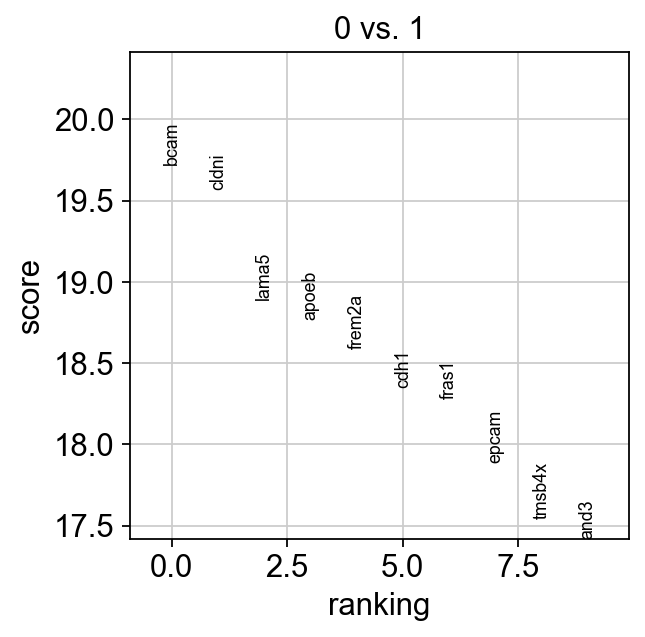

In [70]:
# Compare to a single cluster:

sc.tl.rank_genes_groups(adata, 'leiden', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=10)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


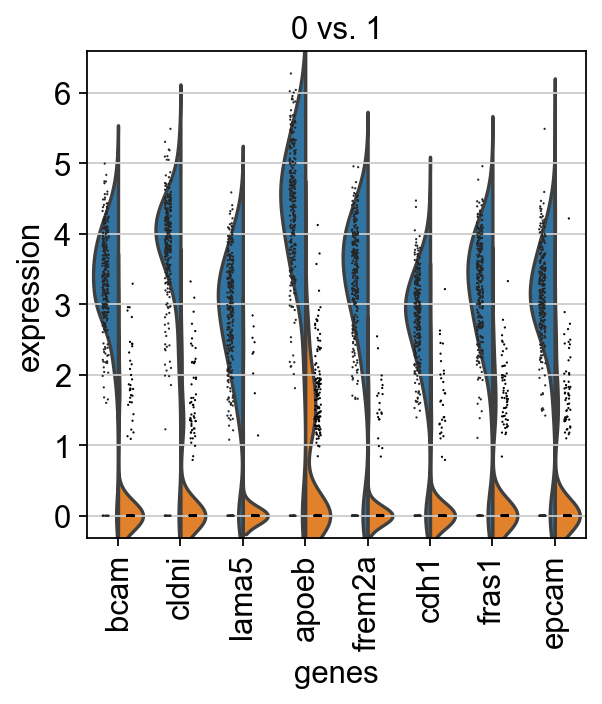

In [73]:
# If we want a more detailed view for a certain group, use sc.pl.rank_genes_groups_violin.

sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)


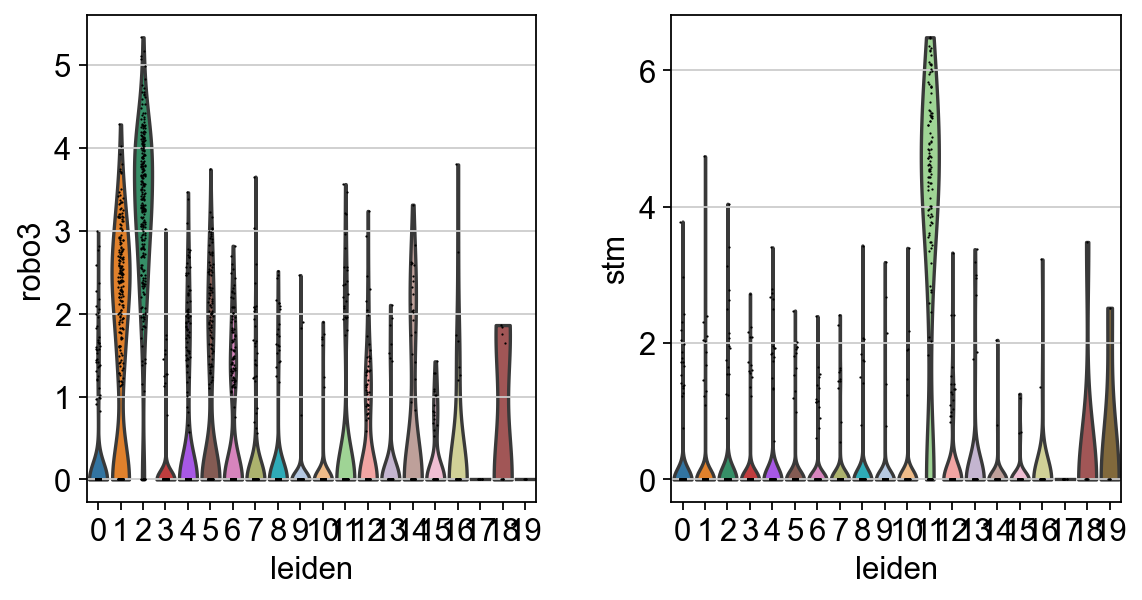

In [76]:
# If you want to compare a certain gene across groups, use the following.

sc.pl.violin(adata, ['robo3', 'stm'], groupby='leiden')


In [78]:
# Actual marked cells
new_cluster_names = ['and3','c1qtnf5','robo3','icn2','fras1','boc','col5al','fn1b',
           'plch2a','evpla','lmo7a','si:rp71-1c10.11','col2a1a','cldna','apoeb','zgc:100868','tcirg1b','CABZ01073083.1'
          ,'si:dkeyp-110a12.4','muc5.2']
adata.rename_categories('leiden', new_cluster_names)

Omitting rank_genes_groups/names as old categories do not match.
Omitting rank_genes_groups/scores as old categories do not match.
Omitting rank_genes_groups/pvals as old categories do not match.
Omitting rank_genes_groups/pvals_adj as old categories do not match.
Omitting rank_genes_groups/logfoldchanges as old categories do not match.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


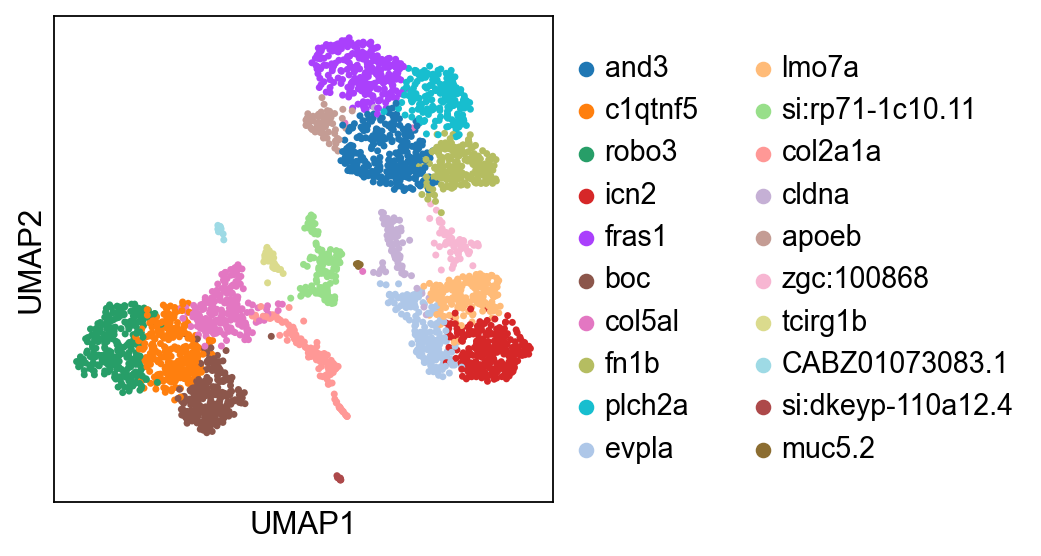

In [83]:
sc.pl.umap(adata, color='leiden', legend_loc='right margin', title='', frameon=True, save='.pdf')

In [82]:
sc.pl.dotplot(adata, markers, groupby='leiden');


KeyError: "Could not find keys '['col5al']' in columns of `adata.obs` or in adata.raw.var_names."